In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_lens_source/mb_lens_source.npy'
target_img_path = head / 'data/mb_lens_target/mb_lens_target.npy'
source_meta = head / 'data/mb_lens_source/mb_lens_source_metadata.csv'
target_meta = head / 'data/mb_lens_target/mb_lens_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

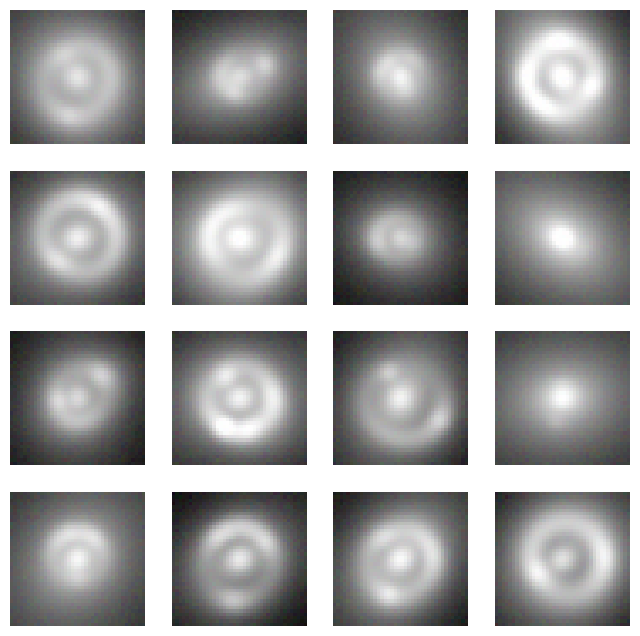

In [3]:
# Visualize source data
visualize_data(source_data)

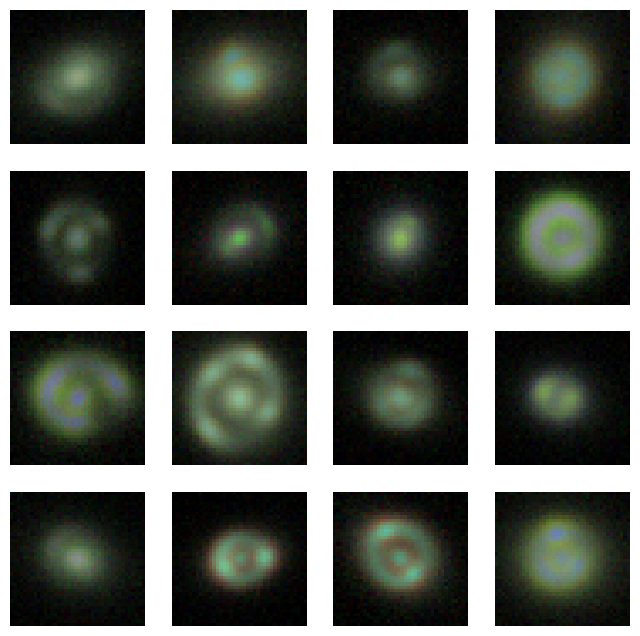

In [4]:
# Visualize target data
visualize_data(target_data)

In [5]:
model = NeuralNetwork().cuda()
learning_rate = 2e-5
epochs = 50
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [6]:
mod_name = None #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...
(2000, 4800)


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


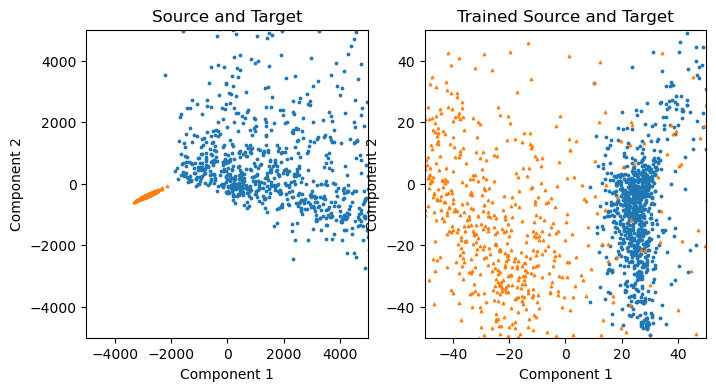

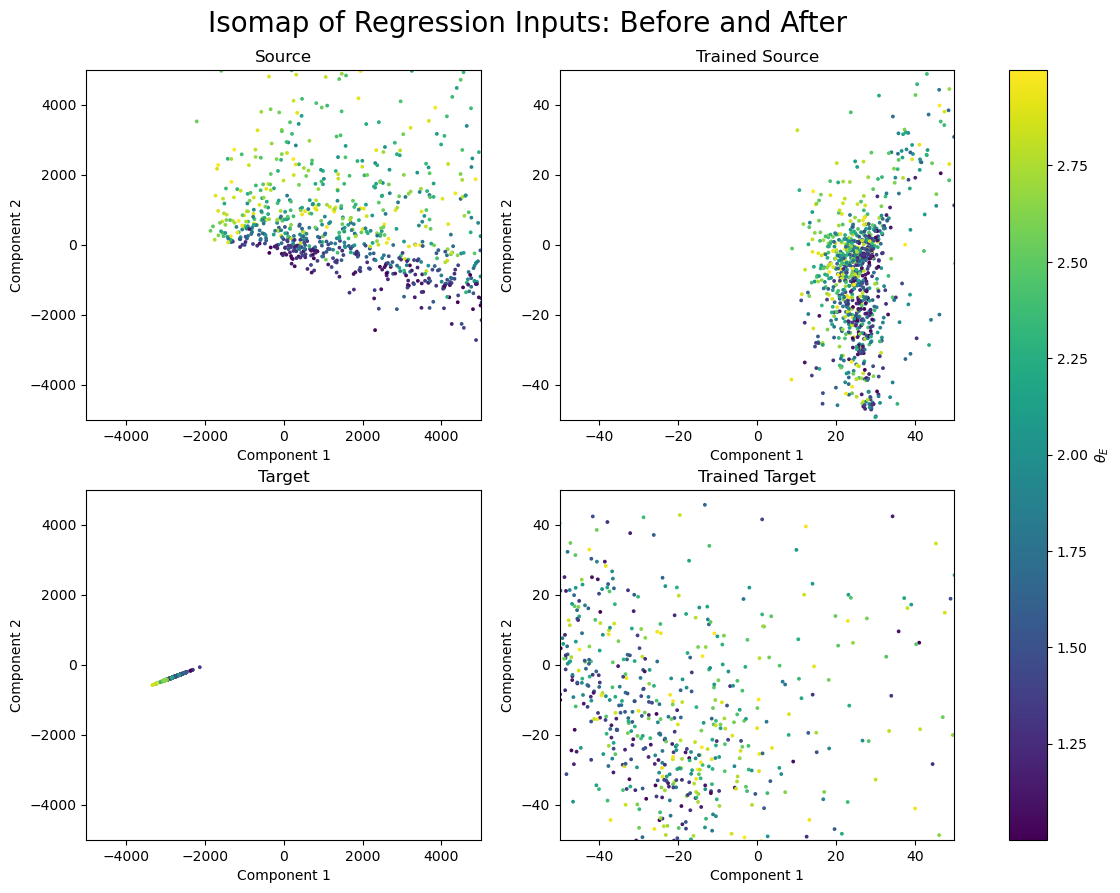


Epoch 0: 20.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2885
	Train Regression Loss: : 0.2732
	Train R2 Score: : 0.1385
 Validation Statistics:
	Val Source Regression Loss: : 0.0583
	Val Target Regression Loss: : 0.1034
	Val Source R2 Score: : 0.8131
	Val Target R2 Score: : 0.6725

Epoch 1: 16.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1612
	Train Regression Loss: : 0.0477
	Train R2 Score: : 0.8497
 Validation Statistics:
	Val Source Regression Loss: : 0.0423
	Val Target Regression Loss: : 0.0710
	Val Source R2 Score: : 0.8656
	Val Target R2 Score: : 0.7733

Epoch 2: 16.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1422
	Train Regression Loss: : 0.0369
	Train R2 Score: : 0.8842
 Validation Statistics:
	Val Source Regression Loss: : 0.0330
	Val Target Regression Loss: : 0.0511
	Val Source R2 Score: : 0.8964
	Val Target R2 Score: : 0.8357

Epoch 3: 16.18s
-------------------------------


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


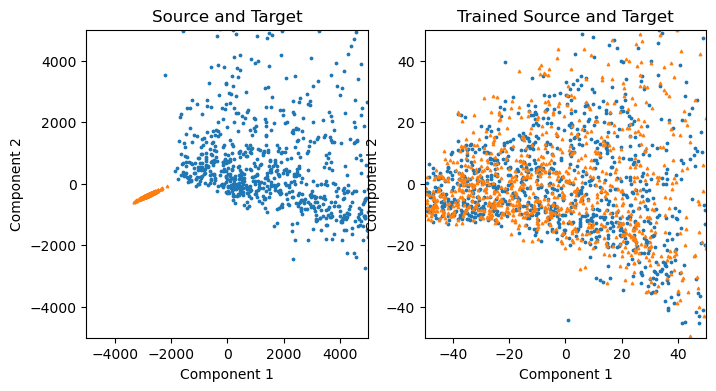

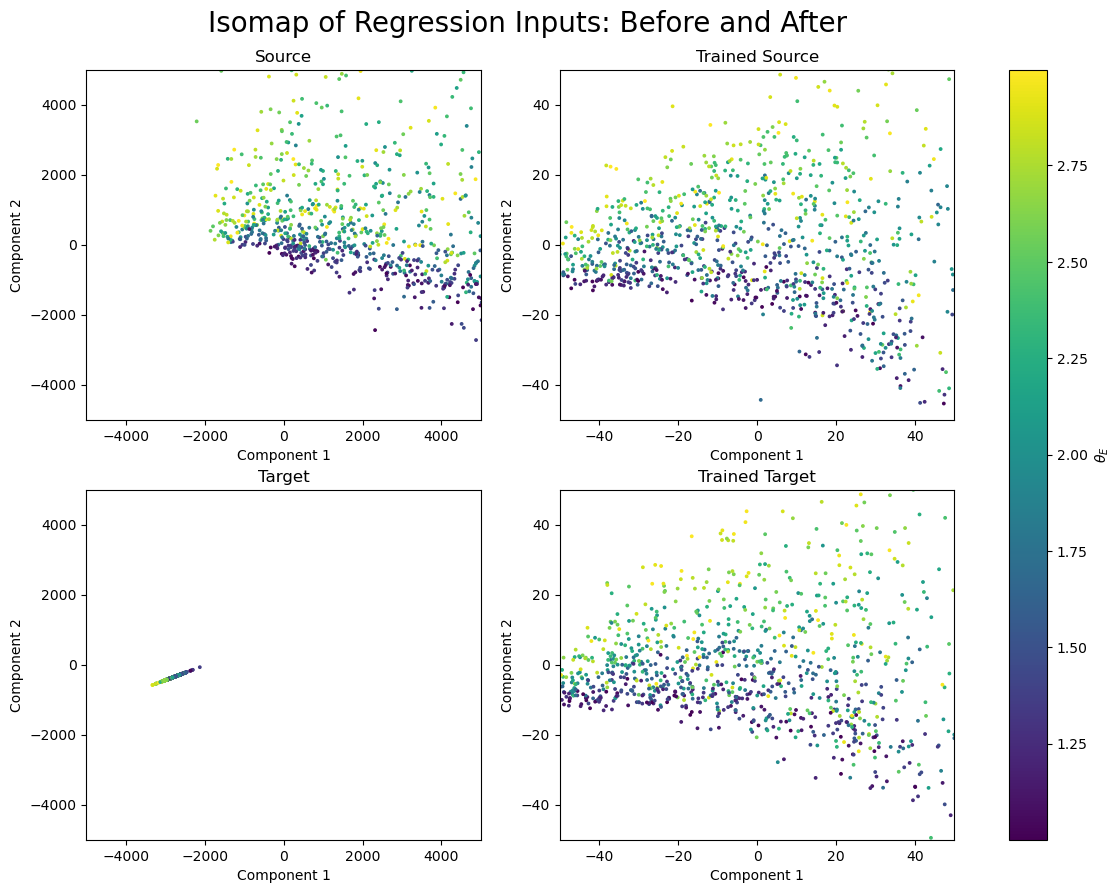


Epoch 5: 18.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1267
	Train Regression Loss: : 0.0240
	Train R2 Score: : 0.9244
 Validation Statistics:
	Val Source Regression Loss: : 0.0223
	Val Target Regression Loss: : 0.0343
	Val Source R2 Score: : 0.9297
	Val Target R2 Score: : 0.8905

Epoch 6: 19.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1250
	Train Regression Loss: : 0.0220
	Train R2 Score: : 0.9306
 Validation Statistics:
	Val Source Regression Loss: : 0.0209
	Val Target Regression Loss: : 0.0308
	Val Source R2 Score: : 0.9345
	Val Target R2 Score: : 0.9019

Epoch 7: 16.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1272
	Train Regression Loss: : 0.0205
	Train R2 Score: : 0.9353
 Validation Statistics:
	Val Source Regression Loss: : 0.0200
	Val Target Regression Loss: : 0.0285
	Val Source R2 Score: : 0.9361
	Val Target R2 Score: : 0.9084

Epoch 8: 17.33s
-------------------------------


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


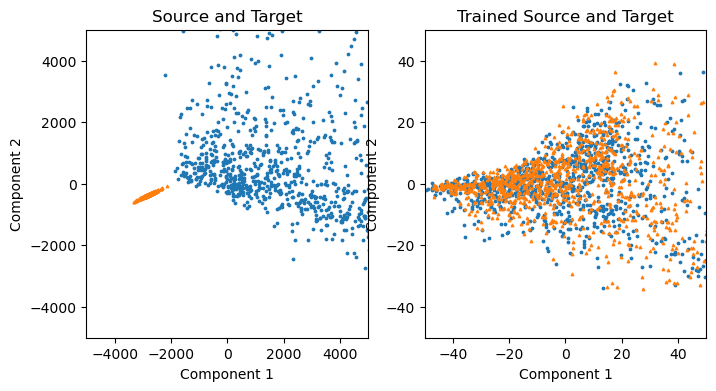

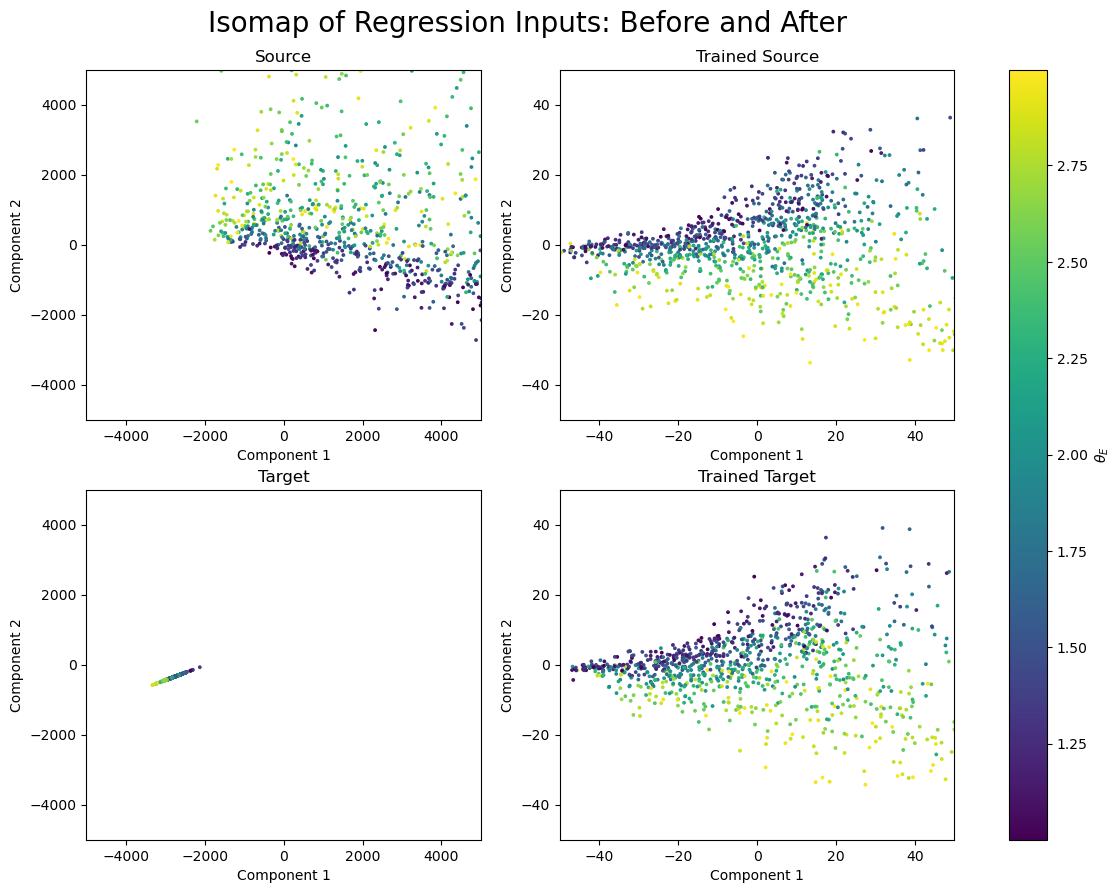


Epoch 10: 19.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1299
	Train Regression Loss: : 0.0182
	Train R2 Score: : 0.9425
 Validation Statistics:
	Val Source Regression Loss: : 0.0179
	Val Target Regression Loss: : 0.0270
	Val Source R2 Score: : 0.9431
	Val Target R2 Score: : 0.9143

Epoch 11: 16.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1301
	Train Regression Loss: : 0.0182
	Train R2 Score: : 0.9425
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0249
	Val Source R2 Score: : 0.9452
	Val Target R2 Score: : 0.9201

Epoch 12: 17.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1310
	Train Regression Loss: : 0.0173
	Train R2 Score: : 0.9453
 Validation Statistics:
	Val Source Regression Loss: : 0.0183
	Val Target Regression Loss: : 0.0252
	Val Source R2 Score: : 0.9412
	Val Target R2 Score: : 0.9168

Epoch 13: 19.14s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


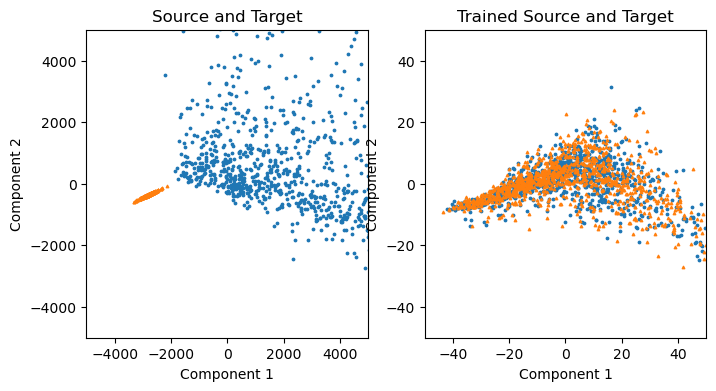

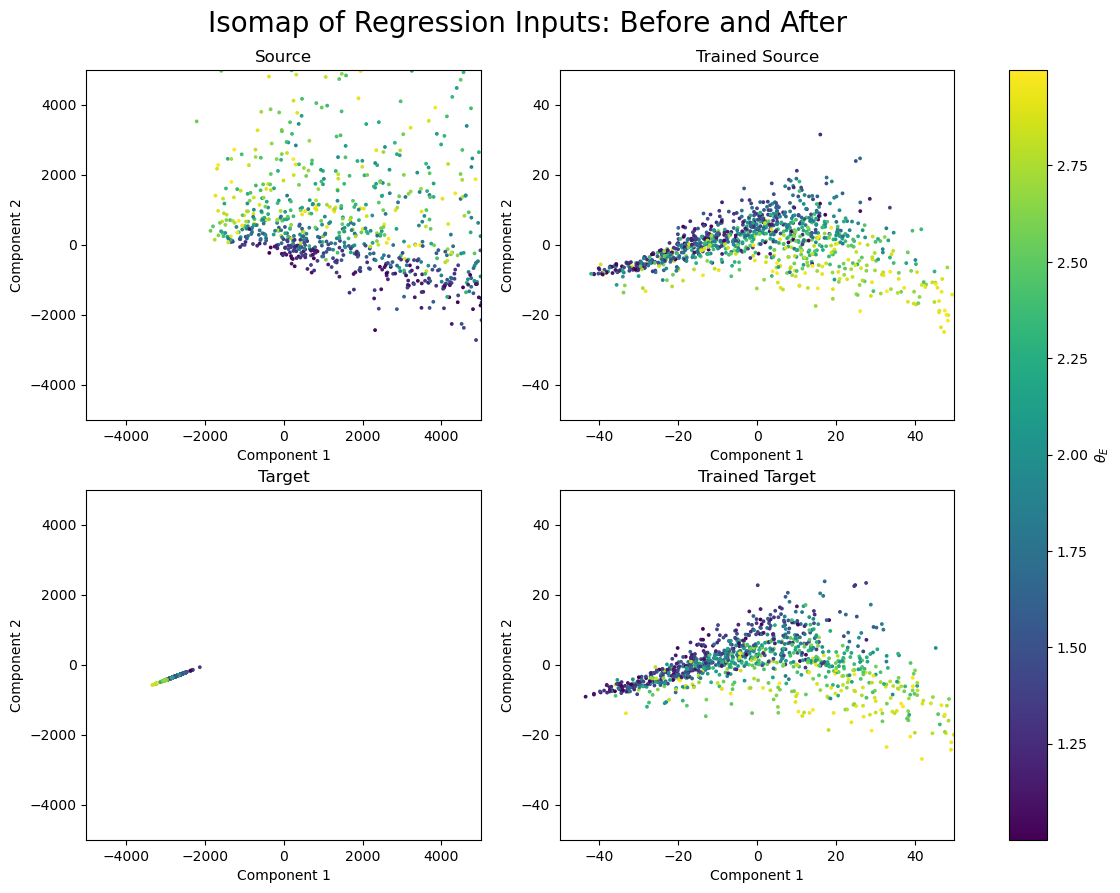


Epoch 15: 18.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1321
	Train Regression Loss: : 0.0166
	Train R2 Score: : 0.9478
 Validation Statistics:
	Val Source Regression Loss: : 0.0158
	Val Target Regression Loss: : 0.0230
	Val Source R2 Score: : 0.9496
	Val Target R2 Score: : 0.9268

Epoch 16: 16.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1334
	Train Regression Loss: : 0.0164
	Train R2 Score: : 0.9479
 Validation Statistics:
	Val Source Regression Loss: : 0.0161
	Val Target Regression Loss: : 0.0232
	Val Source R2 Score: : 0.9487
	Val Target R2 Score: : 0.9254

Epoch 17: 15.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1341
	Train Regression Loss: : 0.0162
	Train R2 Score: : 0.9489
 Validation Statistics:
	Val Source Regression Loss: : 0.0158
	Val Target Regression Loss: : 0.0228
	Val Source R2 Score: : 0.9502
	Val Target R2 Score: : 0.9249

Epoch 18: 14.50s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


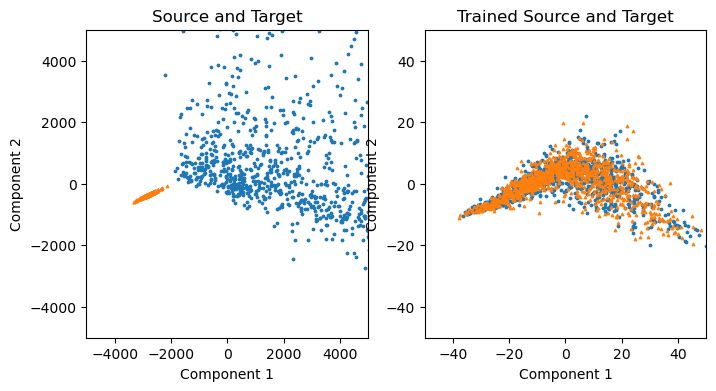

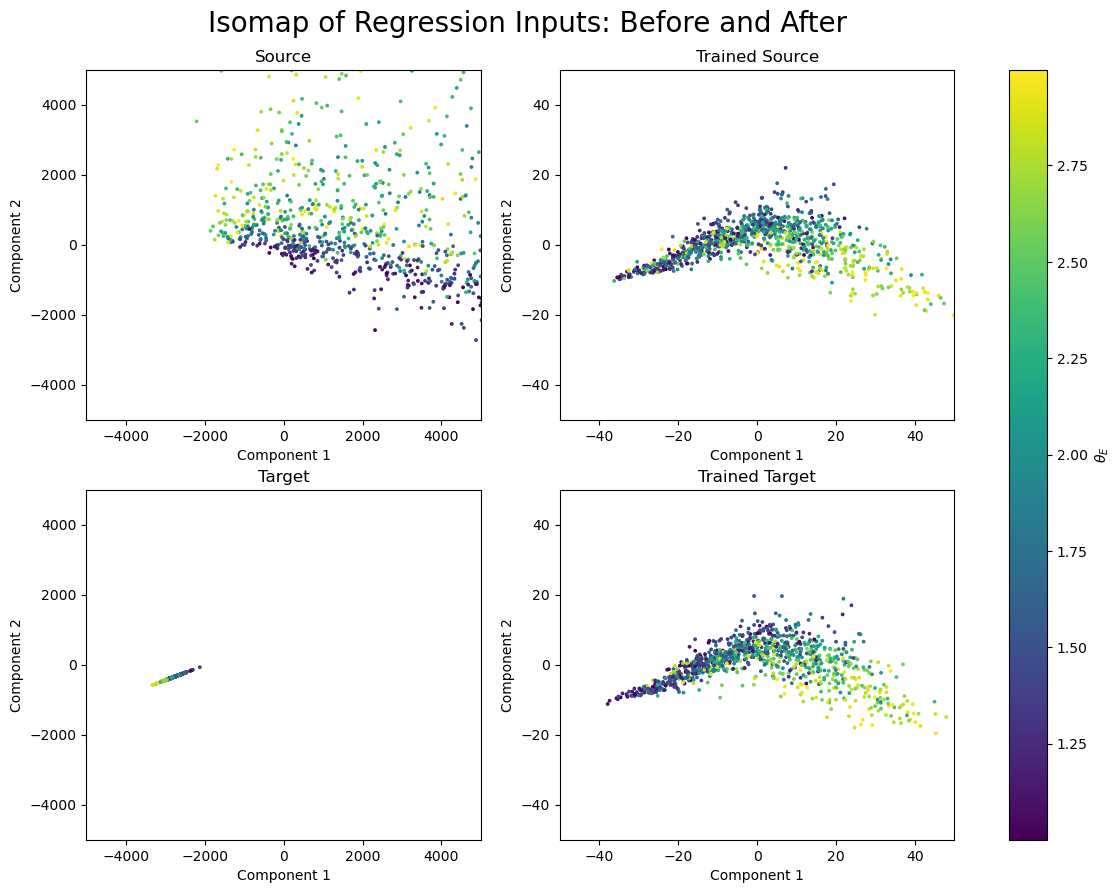


Epoch 20: 16.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1328
	Train Regression Loss: : 0.0158
	Train R2 Score: : 0.9501
 Validation Statistics:
	Val Source Regression Loss: : 0.0154
	Val Target Regression Loss: : 0.0229
	Val Source R2 Score: : 0.9506
	Val Target R2 Score: : 0.9263

Epoch 21: 13.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1342
	Train Regression Loss: : 0.0160
	Train R2 Score: : 0.9495
 Validation Statistics:
	Val Source Regression Loss: : 0.0164
	Val Target Regression Loss: : 0.0221
	Val Source R2 Score: : 0.9477
	Val Target R2 Score: : 0.9290

Epoch 22: 13.77s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1329
	Train Regression Loss: : 0.0156
	Train R2 Score: : 0.9504
 Validation Statistics:
	Val Source Regression Loss: : 0.0186
	Val Target Regression Loss: : 0.0261
	Val Source R2 Score: : 0.9401
	Val Target R2 Score: : 0.9141

Epoch 23: 16.10s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


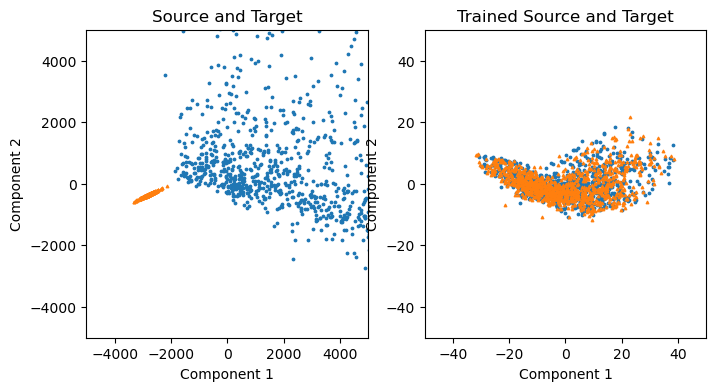

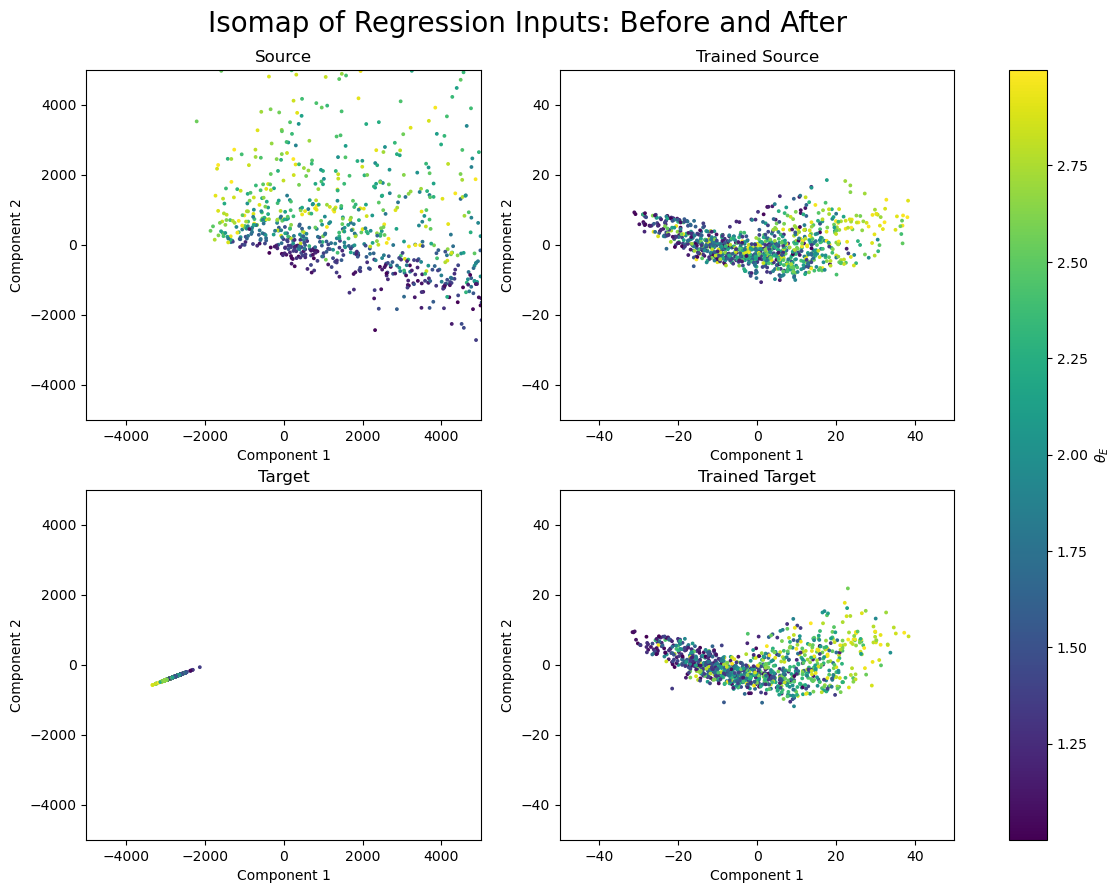


Epoch 25: 18.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1344
	Train Regression Loss: : 0.0151
	Train R2 Score: : 0.9521
 Validation Statistics:
	Val Source Regression Loss: : 0.0212
	Val Target Regression Loss: : 0.0293
	Val Source R2 Score: : 0.9322
	Val Target R2 Score: : 0.9039

Epoch 26: 17.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1376
	Train Regression Loss: : 0.0152
	Train R2 Score: : 0.9521
 Validation Statistics:
	Val Source Regression Loss: : 0.0150
	Val Target Regression Loss: : 0.0232
	Val Source R2 Score: : 0.9531
	Val Target R2 Score: : 0.9255

Epoch 27: 20.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1381
	Train Regression Loss: : 0.0151
	Train R2 Score: : 0.9523
 Validation Statistics:
	Val Source Regression Loss: : 0.0152
	Val Target Regression Loss: : 0.0235
	Val Source R2 Score: : 0.9519
	Val Target R2 Score: : 0.9251

Epoch 28: 22.72s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


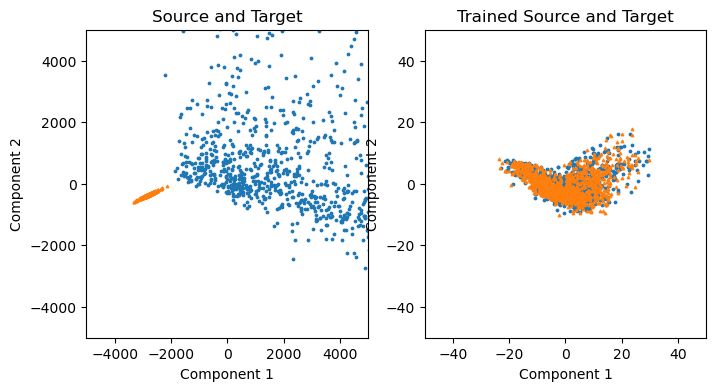

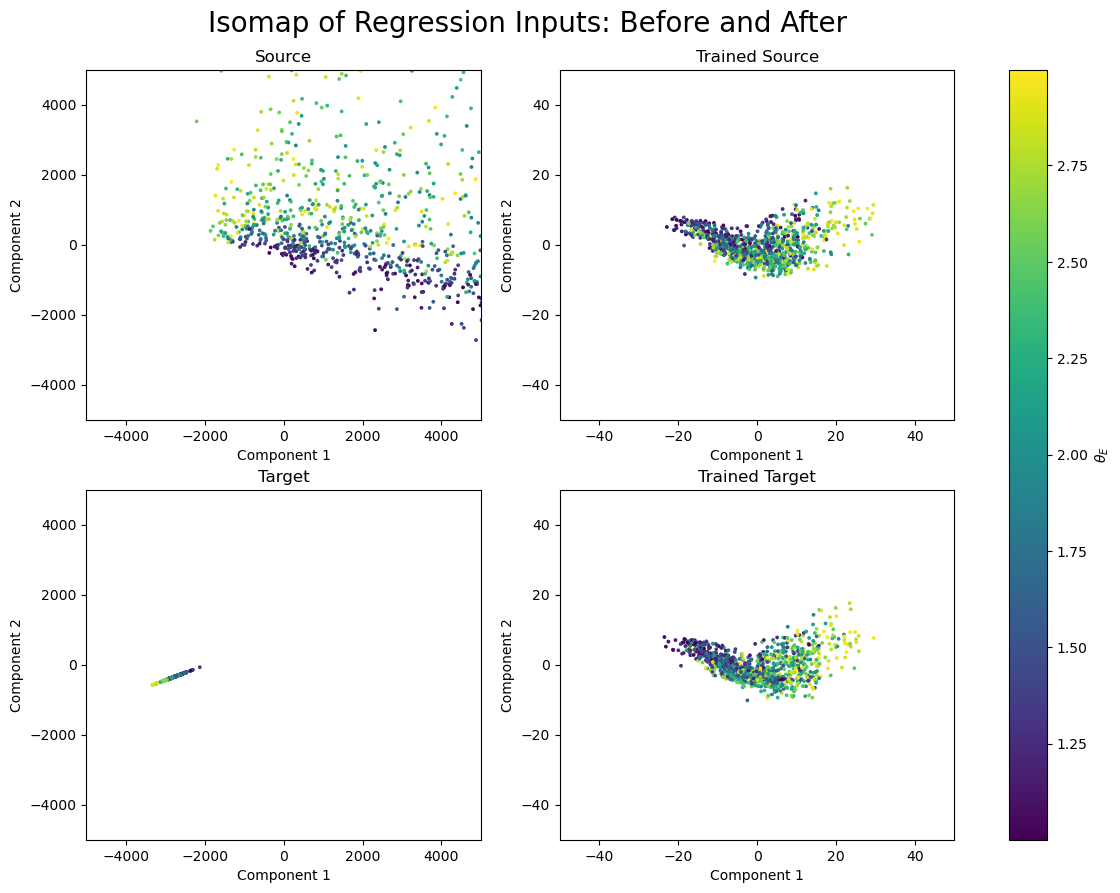


Epoch 30: 22.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1464
	Train Regression Loss: : 0.0165
	Train R2 Score: : 0.9477
 Validation Statistics:
	Val Source Regression Loss: : 0.0166
	Val Target Regression Loss: : 0.0253
	Val Source R2 Score: : 0.9481
	Val Target R2 Score: : 0.9179

Epoch 31: 14.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1475
	Train Regression Loss: : 0.0174
	Train R2 Score: : 0.9449
 Validation Statistics:
	Val Source Regression Loss: : 0.0184
	Val Target Regression Loss: : 0.0265
	Val Source R2 Score: : 0.9409
	Val Target R2 Score: : 0.9129

Epoch 32: 15.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1520
	Train Regression Loss: : 0.0189
	Train R2 Score: : 0.9401
 Validation Statistics:
	Val Source Regression Loss: : 0.0189
	Val Target Regression Loss: : 0.0284
	Val Source R2 Score: : 0.9404
	Val Target R2 Score: : 0.9062

Epoch 33: 15.33s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


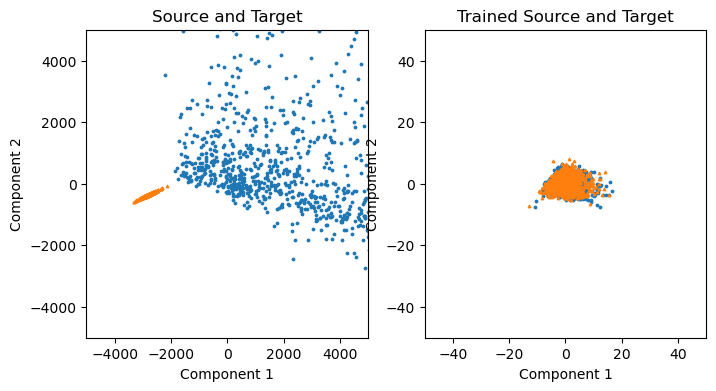

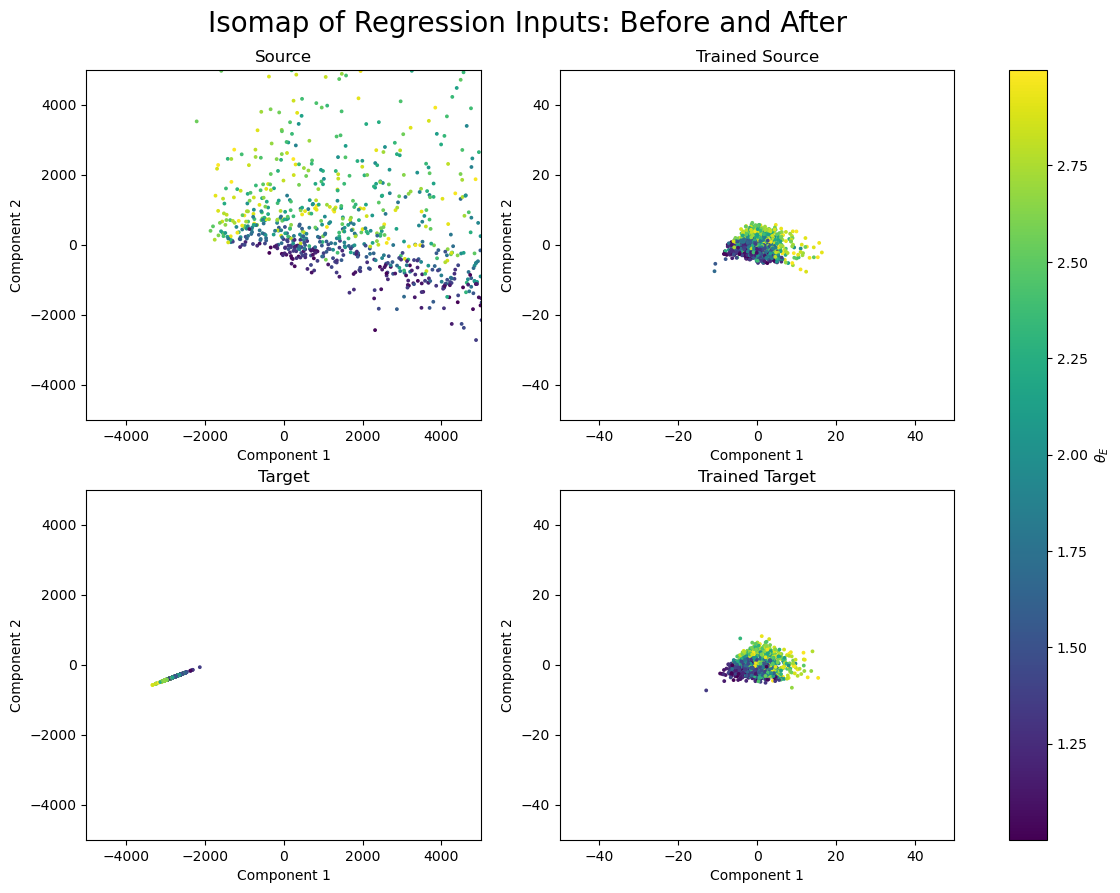


Epoch 35: 22.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1623
	Train Regression Loss: : 0.0219
	Train R2 Score: : 0.9308
 Validation Statistics:
	Val Source Regression Loss: : 0.0213
	Val Target Regression Loss: : 0.0311
	Val Source R2 Score: : 0.9320
	Val Target R2 Score: : 0.8986

Epoch 36: 16.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1633
	Train Regression Loss: : 0.0233
	Train R2 Score: : 0.9260
 Validation Statistics:
	Val Source Regression Loss: : 0.0231
	Val Target Regression Loss: : 0.0315
	Val Source R2 Score: : 0.9264
	Val Target R2 Score: : 0.8998

Epoch 37: 14.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1640
	Train Regression Loss: : 0.0250
	Train R2 Score: : 0.9206
 Validation Statistics:
	Val Source Regression Loss: : 0.0339
	Val Target Regression Loss: : 0.0437
	Val Source R2 Score: : 0.8905
	Val Target R2 Score: : 0.8577

Epoch 38: 14.84s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


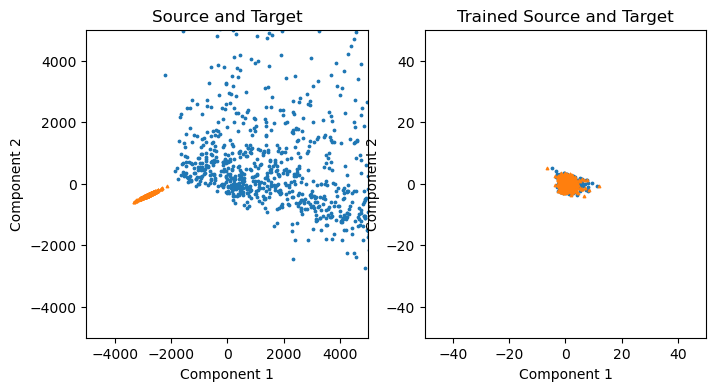

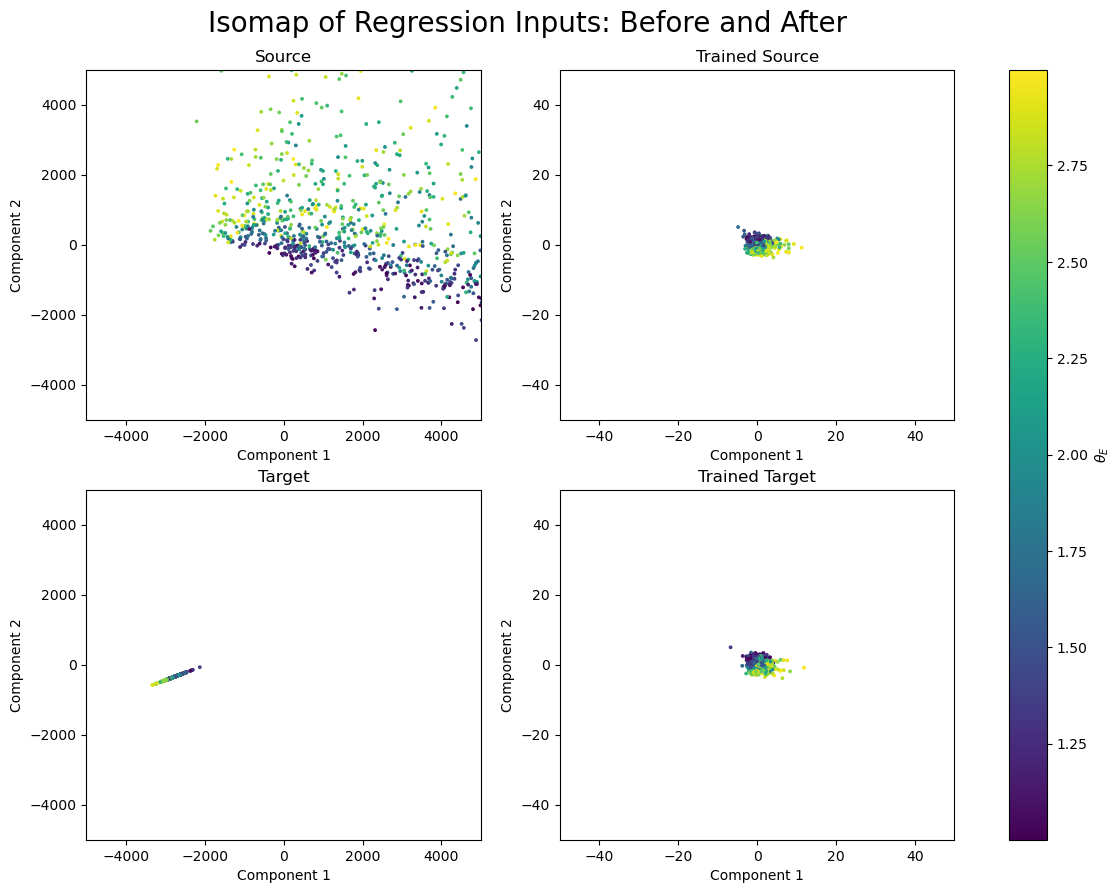


Epoch 40: 17.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1628
	Train Regression Loss: : 0.0285
	Train R2 Score: : 0.9098
 Validation Statistics:
	Val Source Regression Loss: : 0.0282
	Val Target Regression Loss: : 0.0364
	Val Source R2 Score: : 0.9093
	Val Target R2 Score: : 0.8831

Epoch 41: 17.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1651
	Train Regression Loss: : 0.0296
	Train R2 Score: : 0.9058
 Validation Statistics:
	Val Source Regression Loss: : 0.0291
	Val Target Regression Loss: : 0.0374
	Val Source R2 Score: : 0.9078
	Val Target R2 Score: : 0.8785

Epoch 42: 15.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1652
	Train Regression Loss: : 0.0302
	Train R2 Score: : 0.9042
 Validation Statistics:
	Val Source Regression Loss: : 0.0312
	Val Target Regression Loss: : 0.0401
	Val Source R2 Score: : 0.9007
	Val Target R2 Score: : 0.8708

Epoch 43: 12.46s
----------------------------

/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


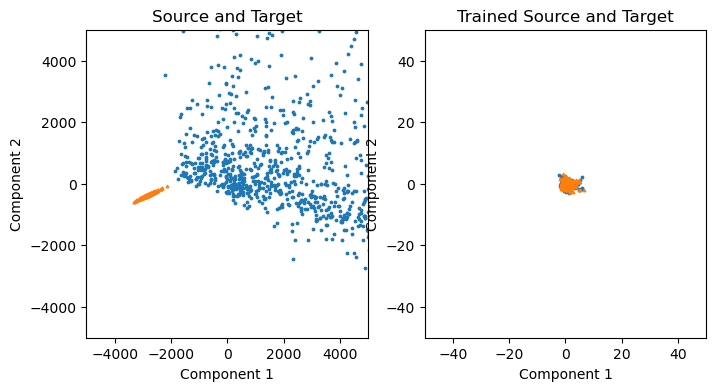

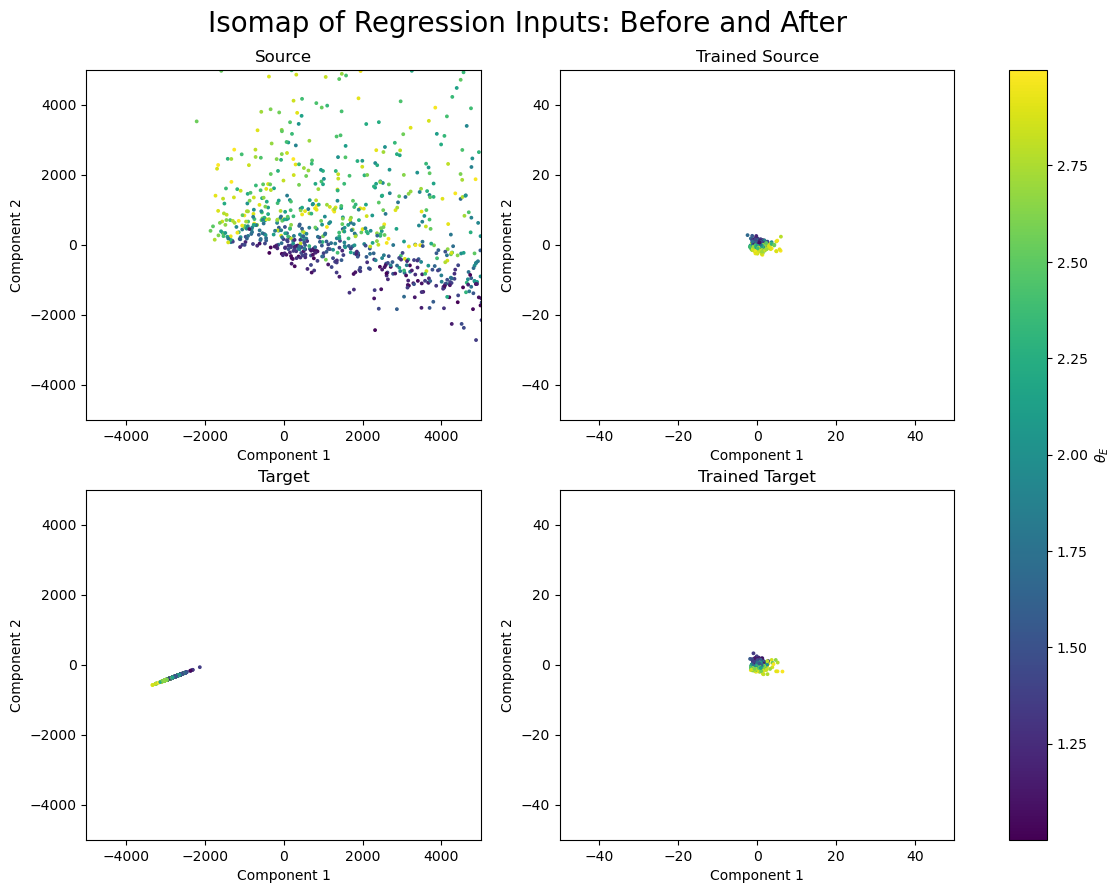


Epoch 45: 19.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1634
	Train Regression Loss: : 0.0327
	Train R2 Score: : 0.8961
 Validation Statistics:
	Val Source Regression Loss: : 0.0326
	Val Target Regression Loss: : 0.0413
	Val Source R2 Score: : 0.8963
	Val Target R2 Score: : 0.8656

Epoch 46: 12.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1627
	Train Regression Loss: : 0.0346
	Train R2 Score: : 0.8903
 Validation Statistics:
	Val Source Regression Loss: : 0.0349
	Val Target Regression Loss: : 0.0429
	Val Source R2 Score: : 0.8892
	Val Target R2 Score: : 0.8627

Epoch 47: 14.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1602
	Train Regression Loss: : 0.0348
	Train R2 Score: : 0.8897
 Validation Statistics:
	Val Source Regression Loss: : 0.0411
	Val Target Regression Loss: : 0.0514
	Val Source R2 Score: : 0.8677
	Val Target R2 Score: : 0.8255

Epoch 48: 12.25s
----------------------------

In [7]:
print("Beginning Training...")
mod_name = "models/mb_lens_jul24_2140_fixvary"
# Train
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 5000, 50, save = True)
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['epoch_no'] += 1
        print_epoch_scores(stats, i, time.time() - start_time)

In [8]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#mod_name = mod_name = "models/mb_isomap_jul22_2153_100ep"
torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [9]:
#mod_name = "models/mb_isomap_jul18_6pm"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

In [10]:
def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [11]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

(2000, 4800)


/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/deepskieslab/agarwal/.conda/envs/neural/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [12]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

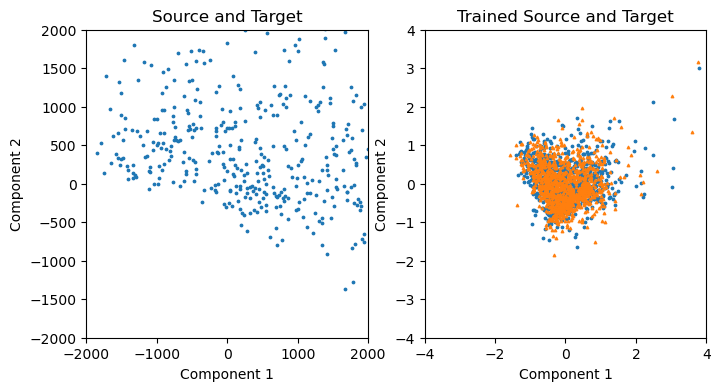

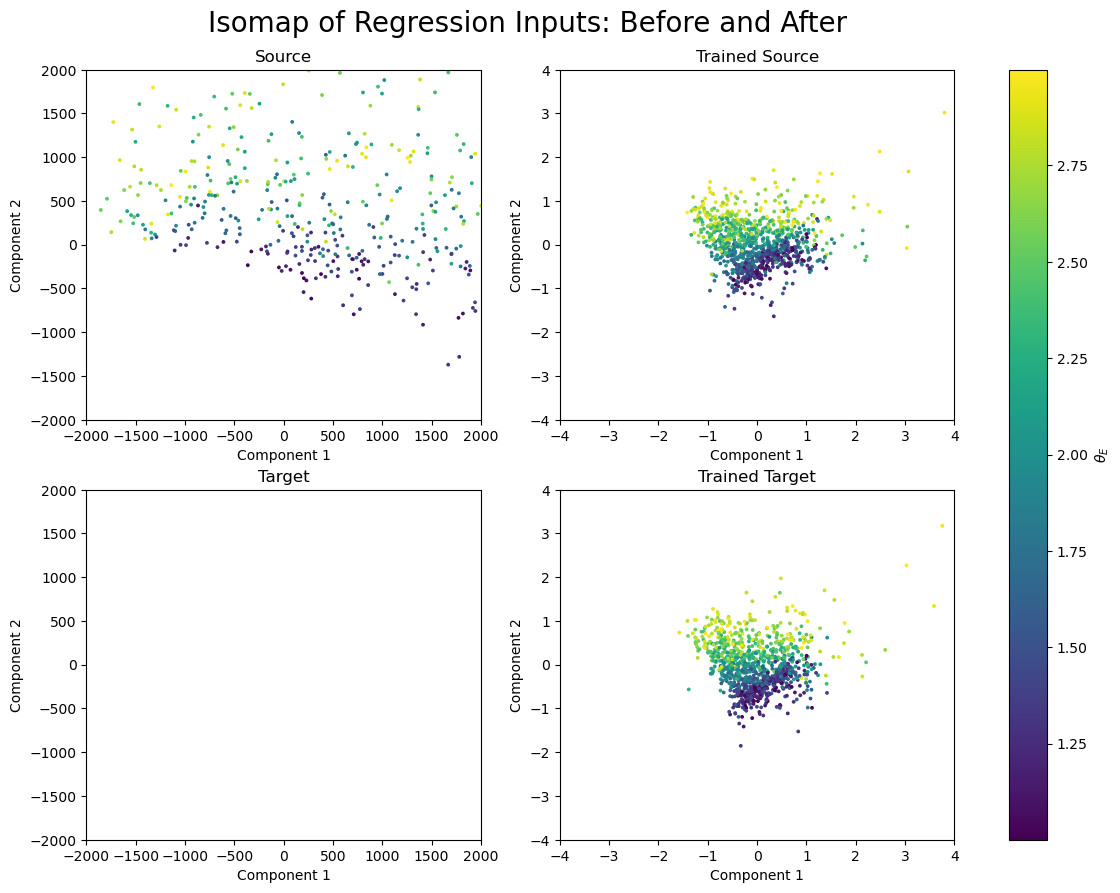

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [13]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 2000, 4)

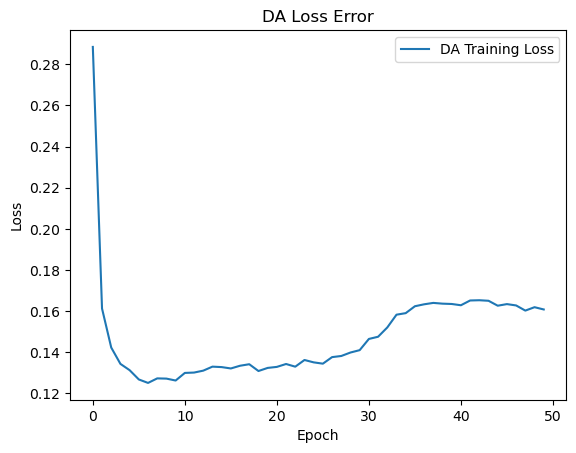

In [14]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

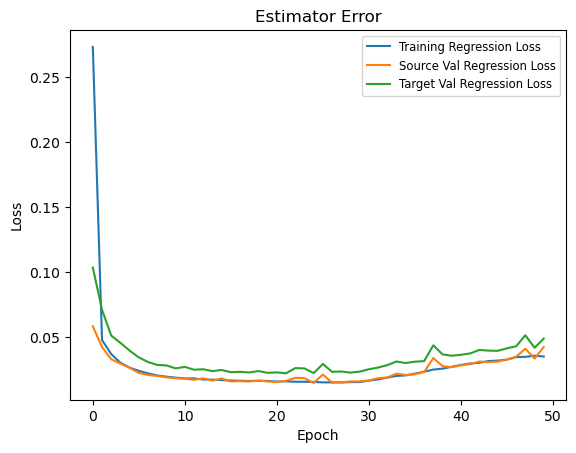

In [15]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

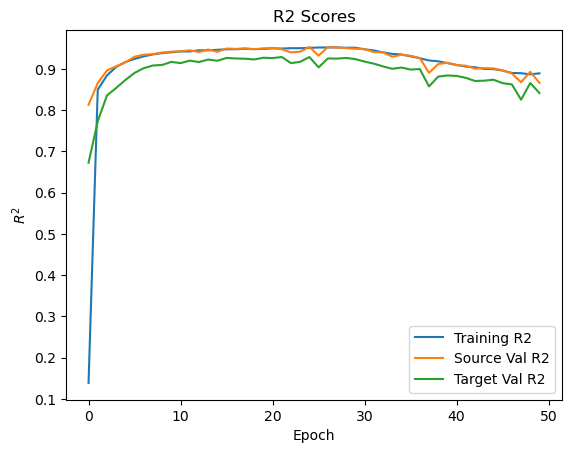

In [16]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.8679


Text(0.5, 1.0, 'MMD | Source | R2: 0.868')

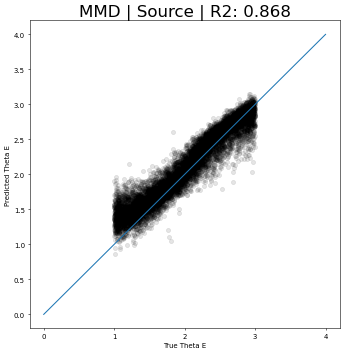

In [17]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.8461


Text(0.5, 1.0, 'MMD | Target | R2: 0.846')

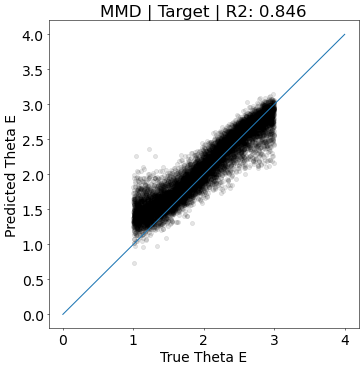

In [18]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))